## Analysis for glutamate imaging

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from utils_swim import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Random Delay

### processing swim data

In [2]:
from pathlib import Path
from skimage.io import imread

/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
rootDir = '/nrs/ahrens/Takashi/GlutamateImaging/'
folder = '04182019_Fish1-3_RandomDelay'
fish = 'Fish1-3-delay'
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
dir_folder = Path(dat_folder)
# swim(folder, fish, rootDir, dat_folder)
# trial_swim_power(folder, fish, dir_folder)
# frame_swim_power(folder, fish, dir_folder)
# frame_swim_power_series(folder, fish, dir_folder)

### preprocessed dff data

In [4]:
# pamamters
swm_dir = dat_folder+f'{folder}/{fish}/swim/'
img_dir = rootDir+folder+'/Registered'

frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15

# get valid swim data
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy')[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy")[()];
rawdata = np.load(swm_dir+"rawdata.npy")[()]
swimdata = np.load(swm_dir+"swimdata.npy")[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
# collect trial within t-pre, and t-post valid range
swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]

In [151]:
# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels

# remove pixels with low light intensity

# ave = imread(img_dir+'/ave.tif')
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0)
ave[:125,:] = 0
# ave[75:125,:] = 0
mask_ = (ave>200) & (ave<np.inf)
ave = ave.reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where((ave>200) & (ave<np.inf))[1]

dFF = dFF[:, include_pix]
n_pix = dFF.shape[-1]

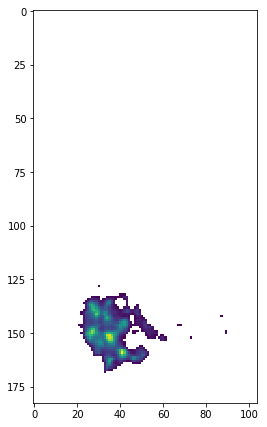

In [152]:
tmp = np.load(img_dir+'/stack_sub.npy')[()]
_ = tmp.mean(axis=0)
plt.figure(figsize=(4, 10))
max_ = _.max()
_[~mask_] = np.nan
plt.imshow(_, vmax=max_)
plt.show()

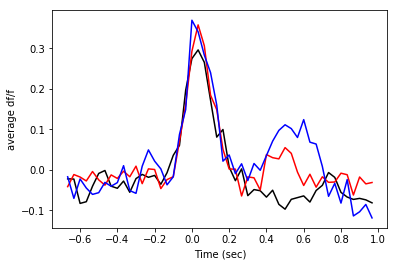

In [153]:
swim_list = []
for ntype in range(3):
    _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
    valid = np.diff(_) > t_post
    swim_list.append(_[:-1][valid])

dff_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    dff_ = np.zeros((num_swim, t_len, n_pix))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*10000
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
    valid_ = np.ones(pswim_.shape[0]).astype('bool')
    valid_ = pswim_[:, -10:].sum(axis=-1)==0
    valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    dff_list.append(dff_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

# fig, ax = plt.subplots(1, 3, figsize=(10, 3))
# ax = ax.flatten()
# color_list = ['k', 'r', 'b']
# for n in range(3):
#     ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
#     ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
#     ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
# plt.show()

color_list = ['k', 'r', 'b']
for n in range(3):
    plt.plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
plt.xlabel('Time (sec)')
plt.ylabel('average df/f')
plt.show()

In [12]:
from sklearn.decomposition import PCA
pca_ = PCA(n_components=300)
pca_.fit(dFF)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
pca_.explained_variance_ratio_.sum()

0.14382174091662828

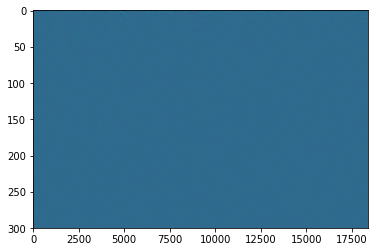

In [14]:
pca_dFF = pca_.transform(dFF)
plt.imshow(pca_dFF.T, aspect='auto')
plt.show()

In [ ]:
plt.plot(pca_.)

In [94]:
from sklearn.decomposition import NMF
nmf_ = NMF(n_components=20)
nmf_.fit(dFF)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [98]:
y = nmf_.transform(dFF)
x_ = nmf_.inverse_transform(y)

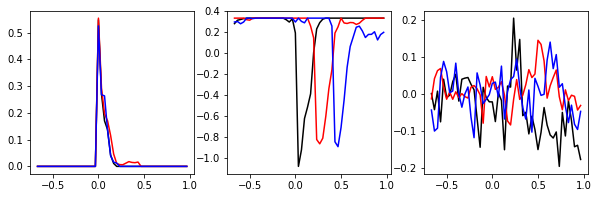

In [104]:
y_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    y_ = np.zeros((num_swim, t_len, 20))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        y_[ns] = y[(s-t_pre):(s+t_post), :] - y[(s-t_flat):s, :].mean(axis=0, keepdims=True)
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*10000
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
    valid_ = pswim_[:, -10:].sum(axis=-1)==0
    valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    y_list.append(y_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax = ax.flatten()
color_list = ['k', 'r', 'b']
for n in range(3):
    ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
    ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
    ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, y_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
plt.show()

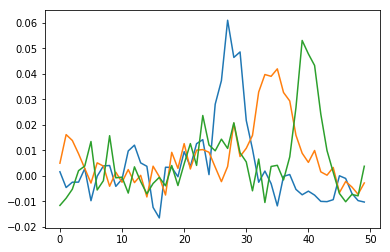

In [115]:
for n in range(3):
    plt.plot(y_list[n].mean(axis=0)[:, 5])
plt.show()

### Random Gain

In [48]:
rootDir = '/nrs/ahrens/Takashi/GlutamateImaging/'
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
folder = '04182019_Fish1-2_RandomGain'
fish = 'Fish1-2-random'
dir_folder = Path(dat_folder)
# swim(folder, fish, dat_folder, dat_folder)
trial_swim_power(folder, fish, dir_folder)
frame_swim_power(folder, fish, dir_folder)
frame_swim_power_series(folder, fish, dir_folder)

In [49]:
# pamamters
swm_dir = dat_folder+f'{folder}/{fish}/swim/'
# swm_dir = rootDir+f'{folder}/swim/'
img_dir = rootDir+folder+'/Registered'

frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15

# get valid swim data
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy')[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy")[()];
rawdata = np.load(swm_dir+"rawdata.npy")[()]
swimdata = np.load(swm_dir+"swimdata.npy")[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
# collect trial within t-pre, and t-post valid range
swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]

In [50]:
# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels

# remove pixels with low light intensity

# ave = imread(img_dir+'/ave.tif')
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0).reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where(ave>150)[1]

dFF = dFF[:, include_pix]
n_pix = dFF.shape[-1]

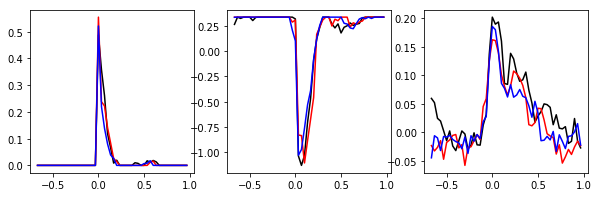

In [61]:
swim_list = []
for ntype in range(3):
    _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
    valid = np.diff(_) > t_post
    swim_list.append(_[:-1][valid])

dff_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    dff_ = np.zeros((num_swim, t_len, n_pix))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*10000
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
    valid_ = pswim_[:, -10:].sum(axis=-1)==0
    valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    dff_list.append(dff_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax = ax.flatten()
color_list = ['k', 'r', 'b']
for n in range(3):
    ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
    ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
    ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])